# Machine Translation: English-French Europarl

This notebook implements three translation approaches:
1. **Baseline**: Word-for-word translation using a bilingual dictionary
2. **Advanced**: Cross-lingual embeddings for semantic translation
3. **Best Model**: Fine-tuned Seq2Seq Transformer (iterative improvement)

We'll evaluate all models on a train/test split of the Europarl corpus.

In [1]:
import sys
import subprocess

required_libraries = [
    "numpy",
    "scikit-learn",         
    "nltk",
    "sentence-transformers",
    "transformers",
    "datasets",
    "accelerate>=0.26.0",   
    "sentencepiece",
    "packaging",
    "torch"
]
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install'] + required_libraries)
    print("All libraries installed successfully!")
except subprocess.CalledProcessError as e:
    print(f"Installation failed. Error: {e}")

All libraries installed successfully!


## 1. Data Loading and Preprocessing

In [2]:
from pathlib import Path
from collections import defaultdict
import re
import pandas as pd

# 1. Setup Paths
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"

# Define the specific files you have
EN_PATH = DATA_DIR / "Europarl.en-fr.en"
FR_PATH = DATA_DIR / "Europarl.en-fr.fr"

# Verify they exist
if EN_PATH.exists() and FR_PATH.exists():
    print(f"Found English file: {EN_PATH.name}")
    print(f"Found French file:  {FR_PATH.name}")
else:
    print("Error: Files not found. Check your folder structure.")

def load_parallel_subset(en_path, fr_path, max_lines):
    """
    Reads two aligned text files and returns a Pandas DataFrame with columns ['en', 'fr'].
    """
    pairs = []
    
    try:
        # Open both files at the same time
        with open(en_path, "r", encoding="utf-8") as f_en, \
             open(fr_path, "r", encoding="utf-8") as f_fr:
            
            # zip() pairs lines together safely
            for i, (line_en, line_fr) in enumerate(zip(f_en, f_fr)):
                if i >= max_lines:
                    break
                
                text_en = line_en.strip()
                text_fr = line_fr.strip()
                
                # Only keep if both sides have content
                if text_en and text_fr:
                    pairs.append((text_en, text_fr))
                    
    except Exception as e:
        print(f"Error reading files: {e}")
        return pd.DataFrame()  # Return empty DF on error

    # Convert list of tuples to DataFrame
    df = pd.DataFrame(pairs, columns=["en", "fr"])
    return df

Found English file: Europarl.en-fr.en
Found French file:  Europarl.en-fr.fr


In [3]:
subset_size = 100000

# Run the loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)
print(f"Successfully loaded {len(df)} pairs.")

Successfully loaded 100000 pairs.


In [4]:
# Run the new loader
df = load_parallel_subset(EN_PATH, FR_PATH, max_lines=subset_size)

# --- THE FIX ---
# Convert back to list of tuples for your old analysis functions
pairs = df.to_records(index=False).tolist()

print(f"DataFrame shape: {df.shape}")
print(f"Pairs list length: {len(pairs)}")

DataFrame shape: (100000, 2)
Pairs list length: 100000


In [5]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_pairs, test_pairs = train_test_split(
    pairs, 
    test_size=0.2, 
    random_state=42,
    shuffle=True 
)

train_pairs[:6]

[('Moreover, a concentration of 10 g/m3 must not be exceeded during that period.',
  'En outre, durant cette période, les intéressés ne pourront pas dépasser une concentration de 10 g/m3.'),
 ('I should point out that the proposal for Serbia for the year 2001 makes provision for a fixed sum of 40 million.',
  "Je peux signaler que, pour 2001, la proposition relative à la Serbie prévoit un chiffre ferme de 40 millions d'euros."),
 ('Of course, I am not saying that there is too much money floating around; as Commissioner for the budget I am aware that money is always scarce, but money is also scarce for those who have to finance the European budget.',
  "Je ne dis naturellement pas qu'il y a trop d'argent dans certains domaines mais, en tant que commissaire en charge du budget, j'ai conscience que, si les ressources sont toujours limitées, elles le sont aussi pour ceux qui doivent financer le budget européen."),
 ('Human rights do not exist in isolation, they are connected to our develop

## 2. Baseline: Word-for-Word Translation

This baseline model builds a bilingual dictionary from the training data and translates each word independently.

In [6]:
class WordForWordTranslator:
    """Baseline word-for-word translation using bilingual dictionary."""
    
    def __init__(self):
        self.word_dict = defaultdict(lambda: defaultdict(int))
        self.most_common_translations = {}
        
    def train(self, train_pairs):
        """Build bilingual dictionary from training pairs."""
        print("Building bilingual dictionary...")
        
        for en_text, fr_text in train_pairs:
            # Simple tokenization (split on whitespace and punctuation)
            en_words = re.findall(r'\b\w+\b', en_text.lower())
            fr_words = re.findall(r'\b\w+\b', fr_text.lower())
            
            if not en_words or not fr_words:
                continue
            
            # Use positional alignment based on relative position
            # This prevents common words like "de" from dominating
            en_len = len(en_words)
            fr_len = len(fr_words)
            
            # Align words based on their relative positions
            for i, en_word in enumerate(en_words):
                # Map English position to French position
                fr_pos = int((i / en_len) * fr_len)
                fr_pos = min(fr_pos, fr_len - 1)  # Ensure valid index
                
                # Align to the word at the corresponding position
                fr_word = fr_words[fr_pos]
                self.word_dict[en_word][fr_word] += 1
                
                # Also align to nearby words (within 1 position) for better coverage
                if fr_pos > 0:
                    self.word_dict[en_word][fr_words[fr_pos - 1]] += 0.5
                if fr_pos < fr_len - 1:
                    self.word_dict[en_word][fr_words[fr_pos + 1]] += 0.5
        
        # Store most common translation for each English word
        for en_word, fr_translations in self.word_dict.items():
            if fr_translations:
                self.most_common_translations[en_word] = max(
                    fr_translations.items(), 
                    key=lambda x: x[1]
                )[0]
        
        print(f"Dictionary built with {len(self.most_common_translations):,} English words")
        
    def translate(self, en_text):
        """Translate English text word-by-word."""
        en_words = re.findall(r'\b\w+\b', en_text)
        fr_words = []
        
        for word in en_words:
            word_lower = word.lower()
            if word_lower in self.most_common_translations:
                fr_words.append(self.most_common_translations[word_lower])
            else:
                # Unknown word - keep original
                fr_words.append(word)
        
        return ' '.join(fr_words)
    
    def translate_preserve_case(self, en_text):
        """Translate preserving original word casing."""
        en_words = re.findall(r'\b\w+\b', en_text)
        fr_words = []
        
        for word in en_words:
            word_lower = word.lower()
            if word_lower in self.most_common_translations:
                translation = self.most_common_translations[word_lower]
                # Preserve case
                if word[0].isupper():
                    translation = translation.capitalize()
                fr_words.append(translation)
            else:
                fr_words.append(word)
        
        return ' '.join(fr_words)


# Train the baseline model
baseline_model = WordForWordTranslator()
baseline_model.train(train_pairs)

Building bilingual dictionary...
Dictionary built with 25,178 English words


In [7]:
# Test the baseline model on a few examples
print("Baseline Translation Examples:\n")
for i, (en, fr_true) in enumerate(test_pairs[:5]):
    fr_pred = baseline_model.translate_preserve_case(en)
    print(f"Example {i+1}:")
    print(f"  EN: {en}")
    print(f"  FR (true):  {fr_true}")
    print(f"  FR (pred):  {fr_pred}")
    print()

Baseline Translation Examples:

Example 1:
  EN: You see, if we want to train professionals effectively, it is essential to teach them to understand the European and international dimensions of the market in their fields - and to do so at European level too.
  FR (true):  Voyez-vous, si nous voulons former des professionnels dans une optique d'efficacité, il est essentiel, y compris au niveau européen, de les former à appréhender les dimensions européenne et internationale du marché dans leurs domaines d'activité.
  FR (pred):  Vous que si nous nous de train professionnels de il est est de à les de je la L et la dimensions de la marché dans de domaines et de ne de à L niveau trop

Example 2:
  EN: This means that their specific importance in many cases, given the significant quantities they have to distribute, is greater than that of the ambassadors and of the Member States.
  FR (true):  Cela signifie que leur poids spécifique est dans de nombreux cas, compte tenu des quantités import

## 3. Advanced Model: Cross-Lingual Embeddings

This model uses pre-trained multilingual embeddings to find the best translation by comparing semantic similarity.

In [8]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class CrossLingualEmbeddingTranslator:
    """Translation using cross-lingual embeddings and semantic similarity."""
    
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        """
        Initialize with a multilingual sentence transformer.
        Options:
        - 'paraphrase-multilingual-MiniLM-L12-v2' (fast, good quality)
        - 'paraphrase-multilingual-mpnet-base-v2' (slower, better quality)
        - 'distiluse-base-multilingual-cased' (alternative)
        """
        print(f"Loading multilingual embedding model: {model_name}...")
        self.model = SentenceTransformer(model_name)
        self.french_candidates = []
        self.french_embeddings = None
        
    def train(self, train_pairs):
        """Build a candidate pool of French translations from training data."""
        print("Building French candidate pool...")
        
        # Collect unique French sentences (or a large sample)
        french_sentences = set()
        for _, fr_text in train_pairs:
            if fr_text.strip():
                french_sentences.add(fr_text.strip())
        
        # Limit to reasonable size for efficiency (can be adjusted)
        max_candidates = 50000
        if len(french_sentences) > max_candidates:
            french_sentences = list(french_sentences)[:max_candidates]
        else:
            french_sentences = list(french_sentences)
        
        self.french_candidates = french_sentences
        
        # Pre-compute embeddings for all French candidates
        print(f"Computing embeddings for {len(self.french_candidates):,} French candidates...")
        self.french_embeddings = self.model.encode(
            self.french_candidates,
            show_progress_bar=True,
            batch_size=32
        )
        print("Training complete!")
        
    def translate(self, en_text, top_k=1):
        """
        Translate by finding the most semantically similar French sentence.
        
        Args:
            en_text: English text to translate
            top_k: Number of top candidates to return (default: 1, returns best match)
        """
        if not en_text.strip():
            return ""
        
        # Get embedding for English text
        en_embedding = self.model.encode([en_text])
        
        # Compute cosine similarity with all French candidates
        similarities = cosine_similarity(en_embedding, self.french_embeddings)[0]
        
        # Get top-k most similar
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        
        if top_k == 1:
            return self.french_candidates[top_indices[0]]
        else:
            return [self.french_candidates[idx] for idx in top_indices]


# Train the cross-lingual embedding model
print("Training cross-lingual embedding model...")
embedding_model = CrossLingualEmbeddingTranslator()
embedding_model.train(train_pairs)

/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training cross-lingual embedding model...
Loading multilingual embedding model: paraphrase-multilingual-MiniLM-L12-v2...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2013.17it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Building French candidate pool...
Computing embeddings for 50,000 French candidates...


Batches: 100%|██████████| 1563/1563 [00:50<00:00, 30.95it/s] 


Training complete!


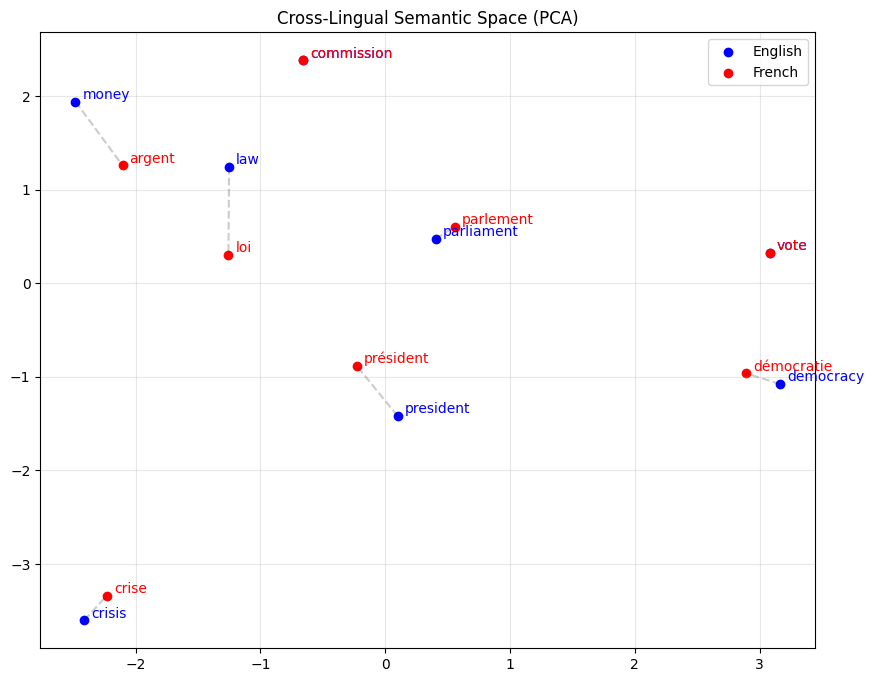

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def visualize_semantics(model, words_en, words_fr):
    """
    Visualizes English and French word pairs in 2D space using PCA.
    """
    # 1. Compute embeddings
    embeddings_en = model.model.encode(words_en)
    embeddings_fr = model.model.encode(words_fr)
    
    # 2. Combine for PCA
    all_embeddings = np.vstack([embeddings_en, embeddings_fr])
    
    # 3. Reduce to 2D
    pca = PCA(n_components=2)
    results = pca.fit_transform(all_embeddings)
    
    # 4. Plot
    plt.figure(figsize=(10, 8))
    
    # Plot English words (Blue)
    plt.scatter(results[:len(words_en), 0], results[:len(words_en), 1], c='blue', label='English')
    for i, word in enumerate(words_en):
        plt.annotate(word, xy=(results[i, 0], results[i, 1]), xytext=(5, 2), 
                     textcoords='offset points', color='blue')
                     
    # Plot French words (Red)
    plt.scatter(results[len(words_en):, 0], results[len(words_en):, 1], c='red', label='French')
    for i, word in enumerate(words_fr):
        plt.annotate(word, xy=(results[len(words_en)+i, 0], results[len(words_en)+i, 1]), 
                     xytext=(5, 2), textcoords='offset points', color='red')
    
    # Draw lines between pairs to show alignment
    for i in range(len(words_en)):
        plt.plot([results[i, 0], results[len(words_en)+i, 0]],
                 [results[i, 1], results[len(words_en)+i, 1]], 
                 'k--', alpha=0.2)

    plt.title('Cross-Lingual Semantic Space (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Define pairs to visualize (conceptually similar words should be close)
concepts = [
    ("democracy", "démocratie"),
    ("parliament", "parlement"),
    ("law", "loi"),
    ("commission", "commission"),
    ("vote", "vote"),
    ("president", "président"),
    ("money", "argent"),
    ("crisis", "crise")
]

words_en = [c[0] for c in concepts]
words_fr = [c[1] for c in concepts]

visualize_semantics(embedding_model, words_en, words_fr)

In [10]:
# Test the embedding model on a few examples
print("Cross-Lingual Embedding Translation Examples:\n")
for i, (en, fr_true) in enumerate(test_pairs[:5]):
    fr_pred = embedding_model.translate(en)
    print(f"Example {i+1}:")
    print(f"  EN: {en}")
    print(f"  FR (true):  {fr_true}")
    print(f"  FR (pred):  {fr_pred}")
    print()

Cross-Lingual Embedding Translation Examples:

Example 1:
  EN: You see, if we want to train professionals effectively, it is essential to teach them to understand the European and international dimensions of the market in their fields - and to do so at European level too.
  FR (true):  Voyez-vous, si nous voulons former des professionnels dans une optique d'efficacité, il est essentiel, y compris au niveau européen, de les former à appréhender les dimensions européenne et internationale du marché dans leurs domaines d'activité.
  FR (pred):  La formation et l' apprentissage sont de plus en plus nettement considérés comme une ressource pour l' Europe.

Example 2:
  EN: This means that their specific importance in many cases, given the significant quantities they have to distribute, is greater than that of the ambassadors and of the Member States.
  FR (true):  Cela signifie que leur poids spécifique est dans de nombreux cas, compte tenu des quantités importantes qu'ils doivent distribu

## 4. Best Model: Fine-tuned Seq2Seq Transformer

This is our iterative improvement model. We'll fine-tune a pretrained transformer model on our Europarl data to achieve the best translation quality.

In [11]:
import torch

# Set device (CUDA, Apple Silicon MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device} (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: {device} (CPU)")

Using device: cuda
GPU: AMD Radeon RX 9070 XT


In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
 )
from datasets import Dataset

class Seq2SeqTranslator:
    """Fine-tuned Seq2Seq Transformer for English-French translation."""
    
    def __init__(self, model_name='Helsinki-NLP/opus-mt-en-fr', max_length=128):
        """
        Initialize with a pretrained translation model.
        
        Options:
        - 'Helsinki-NLP/opus-mt-en-fr' (fast, good baseline, ~300MB)
        - 'facebook/mbart-large-50' (multilingual, better quality, ~2.5GB, needs more GPU)
        - 'google/mt5-base' (multilingual T5, good quality, ~850MB)
        """
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer = None
        self.model = None
        self.device = device
        
        import sentencepiece
        
        print(f"Initializing model: {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.model.to(self.device)
        print(f"Model loaded on {self.device}")
        
    def train(self, train_pairs, val_pairs=None, 
              num_epochs=3, batch_size=8, learning_rate=5e-5,
              save_steps=1000, eval_steps=500, warmup_steps=500):
        """
        Fine-tune the model on training data.
        
        Args:
            train_pairs: List of (en, fr) tuples for training
            val_pairs: Optional validation set (if None, uses 10% of train)
            num_epochs: Number of training epochs
            batch_size: Training batch size (adjust based on GPU memory)
            learning_rate: Learning rate for fine-tuning
            save_steps: Save checkpoint every N steps
            eval_steps: Evaluate every N steps
            warmup_steps: Warmup steps for learning rate scheduler
        """
        print(f"\n{'='*60}")
        print("Training Seq2Seq Transformer Model")
        print(f"{'='*60}")
        print(f"Training examples: {len(train_pairs):,}")

        import json 
        import os     

        # Prepare validation set
        if val_pairs is None:
            # Use 10% of training data for validation
            val_size = max(1000, len(train_pairs) // 10)
            val_pairs = train_pairs[:val_size]
            train_pairs = train_pairs[val_size:]
            print(f"Split: {len(train_pairs):,} train, {len(val_pairs):,} validation")
        
        # Convert to HuggingFace Dataset format
        def prepare_dataset(pairs):
            return Dataset.from_dict({
                'en': [pair[0] for pair in pairs],
                'fr': [pair[1] for pair in pairs]
            })
        
        train_dataset = prepare_dataset(train_pairs)
        val_dataset = prepare_dataset(val_pairs)
        
        # Tokenize datasets
        def tokenize_function(examples):
            # Tokenize English (Source)
            model_inputs = self.tokenizer(
                examples['en'], 
                max_length=self.max_length, 
                truncation=True, 
                padding='max_length'
            )
            
            # Tokenize French (Target) - NEW SYNTAX
            # We use `text_target` instead of context manager
            labels = self.tokenizer(
                text_target=examples['fr'], 
                max_length=self.max_length, 
                truncation=True, 
                padding='max_length'
            )
            
            # Replace padding token id's of the labels with -100 (ignored by loss)
            model_inputs['labels'] = [
                [(l if l != self.tokenizer.pad_token_id else -100) for l in label]
                for label in labels['input_ids']
            ]
            return model_inputs
        
        print("Tokenizing datasets...")
        train_dataset = train_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=train_dataset.column_names
        )
        val_dataset = val_dataset.map(
            tokenize_function,
            batched=True,
            remove_columns=val_dataset.column_names
        )
        
        # Data collator
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model,
            padding=True
        )
        
        # Training arguments
        output_dir = f"./seq2seq_model_{self.model_name.split('/')[-1]}"
        
        training_args = Seq2SeqTrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=warmup_steps,
            weight_decay=0.01,
            logging_dir=f'{output_dir}/logs',
            logging_steps=100,
            eval_steps=eval_steps,
            save_steps=save_steps,
            eval_strategy="steps",
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            fp16=torch.cuda.is_available(),  # Use mixed precision if CUDA GPU available (MPS doesn't support fp16)
            report_to="none",  # Disable wandb/tensorboard
        )
        
        # Trainer
        trainer = Seq2SeqTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
            processing_class=self.tokenizer,
        )
        
        # Train!
        print("\nStarting training...")
        print(f"Epochs: {num_epochs}, Batch size: {batch_size}, Learning rate: {learning_rate}")
        if torch.cuda.is_available():
            print(f"GPU: CUDA available")
        elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            print(f"GPU: Apple Silicon (MPS) available")
        else:
            print(f"Using: CPU")
        
        train_result = trainer.train()
        
        print(f"\nTraining completed!")
        print(f"Training loss: {train_result.training_loss:.4f}")
        
        # Save final model
        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)
        print(f"Model saved to {output_dir}")

        log_history_path = os.path.join(output_dir, "training_logs.json")
        with open(log_history_path, "w") as f:
            json.dump(trainer.state.log_history, f)
        print(f"Training logs saved to {log_history_path}")
        
        return trainer
    
    def translate(self, en_text, max_length=None, num_beams=4, do_sample=False):
        """
        Translate English text to French.
        
        Args:
            en_text: English text to translate
            max_length: Maximum output length (default: self.max_length)
            num_beams: Number of beams for beam search (higher = better quality, slower)
            do_sample: Whether to use sampling (False = deterministic)
        """
        if max_length is None:
            max_length = self.max_length
        
        # Tokenize input
        inputs = self.tokenizer(
            en_text,
            return_tensors="pt",
            max_length=self.max_length,
            truncation=True,
            padding=True
        ).to(self.device)
        
        # Generate translation
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                num_beams=num_beams,
                do_sample=do_sample,
                early_stopping=True,
                num_return_sequences=1
            )
        
        # Decode
        translation = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return translation
    
    def translate_batch(self, en_texts, batch_size=8, **kwargs):
        """Translate a batch of English texts."""
        translations = []
        for i in range(0, len(en_texts), batch_size):
            batch = en_texts[i:i+batch_size]
            batch_translations = [self.translate(text, **kwargs) for text in batch]
            translations.extend(batch_translations)
        return translations

In [13]:
# Initialize the seq2seq model
# You can adjust the model_name to try different pretrained models
# For faster training/testing, start with opus-mt-en-fr
# For better quality (if you have GPU memory), try mBART or mT5

seq2seq_model = Seq2SeqTranslator(
    model_name='Helsinki-NLP/opus-mt-en-fr',  # Good baseline, fast
    max_length=128
)

print("\nModel initialized and ready for training!")
print("Note: Training will take time. Adjust batch_size and num_epochs based on your GPU memory.")

Initializing model: Helsinki-NLP/opus-mt-en-fr...


/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Loading weights: 100%|██████████| 258/258 [00:00<00:00, 2071.35it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Model loaded on cuda

Model initialized and ready for training!
Note: Training will take time. Adjust batch_size and num_epochs based on your GPU memory.


### Training Configuration

**Adjust these parameters based on your resources:**

- **CUDA GPU (NVIDIA)**: Use larger batch_size (16-32), more epochs (3-5), fp16 enabled
- **Apple Silicon GPU (M1/M2/M3)**: Use moderate batch_size (8-16), more epochs (3-5), no fp16
- **CPU only**: Use smaller batch_size (2-4), fewer epochs (1-2), expect slower training
- **Limited GPU memory**: Reduce batch_size, use gradient accumulation

**Model options:**
- `Helsinki-NLP/opus-mt-en-fr`: Fast, ~300MB, good for quick iteration
- `facebook/mbart-large-50`: Better quality, ~2.5GB, needs more GPU memory
- `google/mt5-base`: Good balance, ~850MB

**Note for Apple Silicon (MacBook):**
- The code automatically detects and uses MPS (Metal Performance Shaders)
- Training will be faster than CPU but may be slower than high-end NVIDIA GPUs
- Some operations may fall back to CPU if not supported by MPS
- Mixed precision (fp16) is not supported on MPS, so training uses full precision

In [14]:
# Train the seq2seq model
# Adjust parameters based on your GPU/CPU and time constraints

# For quick testing (CPU or limited time):
# seq2seq_model.train(
#     train_pairs,
#     num_epochs=1,
#     batch_size=4 if not torch.cuda.is_available() else 8,
#     learning_rate=5e-5,
#     save_steps=500,
#     eval_steps=250
# )

# For better results (with GPU):
# Determine batch size based on available device
if torch.cuda.is_available():
    batch_size = 16  # CUDA GPU - can use larger batches
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    batch_size = 8   # Apple Silicon GPU - moderate batch size
else:
    batch_size = 4   # CPU - smaller batches

trainer = seq2seq_model.train(
    train_pairs,
    num_epochs=3,  # Increase to 5-10 for better results
    batch_size=batch_size,
    learning_rate=5e-5,  # Try 3e-5 or 1e-4 for experimentation
    save_steps=1000,
    eval_steps=500,
    warmup_steps=500
)

print("\nTraining complete! Model is ready for evaluation.")


Training Seq2Seq Transformer Model
Training examples: 80,000
Split: 72,000 train, 8,000 validation
Tokenizing datasets...


Map: 100%|██████████| 8000/8000 [00:02<00:00, 2700.00 examples/s]
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.



Starting training...
Epochs: 3, Batch size: 16, Learning rate: 5e-05
GPU: CUDA available


Step,Training Loss,Validation Loss
500,1.187804,1.170726
1000,1.221087,1.179290
1500,1.219660,1.165122
2000,1.204351,1.164103
2500,1.188717,1.161405
3000,1.202031,1.153084
3500,1.201876,1.147898
4000,1.233036,1.142037
4500,1.205621,1.139082
5000,1.062429,1.144492


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight', 'lm_head.weight'].



Training completed!
Training loss: 1.0562


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

Model saved to ./seq2seq_model_opus-mt-en-fr
Training logs saved to ./seq2seq_model_opus-mt-en-fr/training_logs.json

Training complete! Model is ready for evaluation.


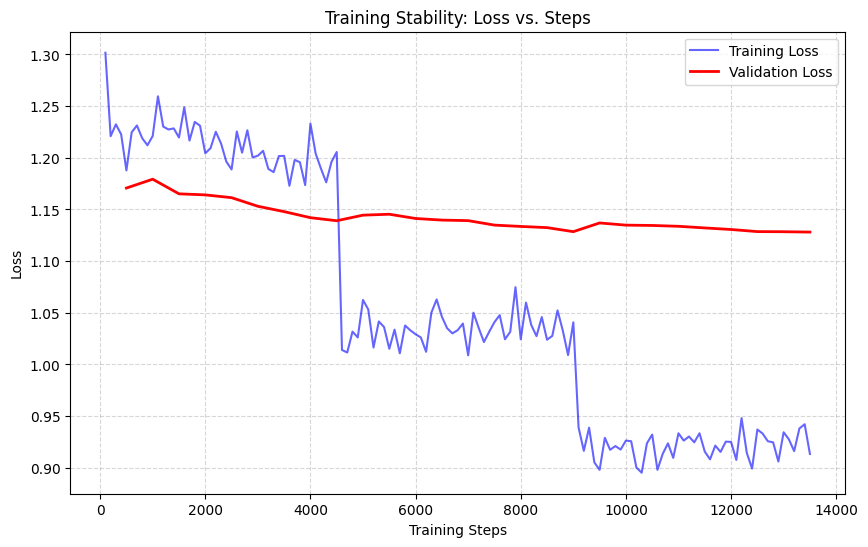

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(trainer):
    """
    Plots the training and validation loss from the HuggingFace Trainer history.
    """
    # Retrieve logs
    history = trainer.state.log_history
    
    # Extract loss values
    train_loss = []
    val_loss = []
    train_steps = []
    val_steps = []
    
    for entry in history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            train_steps.append(entry['step'])
        if 'eval_loss' in entry:
            val_loss.append(entry['eval_loss'])
            val_steps.append(entry['step'])
            
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.6)
    plt.plot(val_steps, val_loss, label='Validation Loss', color='red', linewidth=2)
    
    plt.title('Training Stability: Loss vs. Steps')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

plot_training_history(trainer)

In [16]:
# Test the seq2seq model on a few examples
print("Seq2Seq Transformer Translation Examples:\n")
for i, (en, fr_true) in enumerate(test_pairs[:5]):
    fr_pred = seq2seq_model.translate(en, num_beams=4)
    print(f"Example {i+1}:")
    print(f"  EN: {en}")
    print(f"  FR (true):  {fr_true}")
    print(f"  FR (pred):  {fr_pred}")
    print()

Seq2Seq Transformer Translation Examples:

Example 1:
  EN: You see, if we want to train professionals effectively, it is essential to teach them to understand the European and international dimensions of the market in their fields - and to do so at European level too.
  FR (true):  Voyez-vous, si nous voulons former des professionnels dans une optique d'efficacité, il est essentiel, y compris au niveau européen, de les former à appréhender les dimensions européenne et internationale du marché dans leurs domaines d'activité.
  FR (pred):  Vous voyez, si nous voulons former efficacement les professionnels, il est essentiel de leur apprendre à comprendre les dimensions européennes et internationales du marché dans leurs domaines - et de le faire également au niveau européen.

Example 2:
  EN: This means that their specific importance in many cases, given the significant quantities they have to distribute, is greater than that of the ambassadors and of the Member States.
  FR (true):  Cel

## 5. Evaluation

We'll evaluate all three models using BLEU score and other metrics.

In [20]:
import os
import json
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

# --- FIX 1: Download necessary NLTK data automatically ---
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    print("Downloading missing NLTK resource: punkt_tab")
    nltk.download('punkt_tab')
    nltk.download('punkt')

def evaluate_translations(model, test_pairs, model_name="Model", max_samples=None, save_dir="./results"):
    """
    Evaluate translation model on test set and SAVE RESULTS to disk.
    """
    # --- FIX 2: Ensure save directory exists immediately ---
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if max_samples:
        test_subset = test_pairs[:max_samples]
    else:
        test_subset = test_pairs
    
    print(f"Evaluating {model_name} on {len(test_subset):,} test examples...")
    
    predictions = []
    references = []
    bleu_scores = []
    exact_matches = 0
    smoothing = SmoothingFunction().method1
    
    for i, (en, fr_true) in enumerate(test_subset):
        try:
            # Handle different model output types
            fr_pred = model.translate(en)
            if isinstance(fr_pred, list): 
                fr_pred = fr_pred[0] 
            
            predictions.append(fr_pred)
            references.append(fr_true)
            
            # Tokenize for BLEU (using the downloaded punkt_tab)
            pred_tokens = word_tokenize(fr_pred.lower())
            ref_tokens = word_tokenize(fr_true.lower())
            
            # Calculate BLEU score
            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothing)
            bleu_scores.append(bleu)
            
            # Exact match
            if fr_pred.lower().strip() == fr_true.lower().strip():
                exact_matches += 1
                
        except Exception as e:
            print(f"Error on example {i}: {e}")
            continue
        
        if (i + 1) % 1000 == 0:
            print(f"  Processed {i+1:,} examples...")
    
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    exact_match_rate = exact_matches / len(test_subset) if test_subset else 0.0
    
    results = {
        'model_name': model_name,
        'avg_bleu': float(avg_bleu),
        'exact_match_rate': float(exact_match_rate),
        'num_evaluated': len(test_subset),
        'predictions': predictions,
        'references': references
    }
    
    print(f"\n{model_name} Results:")
    print(f"  Average BLEU Score: {avg_bleu:.4f}")
    print(f"  Exact Match Rate: {exact_match_rate:.4f} ({exact_matches}/{len(test_subset)})")

    # Save results
    safe_name = model_name.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")
    save_path = os.path.join(save_dir, f"{safe_name}_results.json")
    
    with open(save_path, "w", encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    print(f"Results saved to {save_path}")
    
    return results

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mhayakawa/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /home/mhayakawa/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
# Evaluate baseline model
# Using a subset for faster evaluation (adjust as needed)
print("=" * 60)
baseline_results = evaluate_translations(
    baseline_model, 
    test_pairs, 
    model_name="Baseline (Word-for-Word)",
    max_samples=1000  # Evaluate on first 1000 for speed
)

Evaluating Baseline (Word-for-Word) on 1,000 test examples...
  Processed 1,000 examples...

Baseline (Word-for-Word) Results:
  Average BLEU Score: 0.0363
  Exact Match Rate: 0.0000 (0/1000)
Results saved to ./results/Baseline_Word-for-Word_results.json


In [23]:
# Evaluate embedding model
print("=" * 60)
embedding_results = evaluate_translations(
    embedding_model,
    test_pairs,
    model_name="Advanced (Cross-Lingual Embeddings)",
    max_samples=1000  # Evaluate on first 1000 for speed
)

Evaluating Advanced (Cross-Lingual Embeddings) on 1,000 test examples...
  Processed 1,000 examples...

Advanced (Cross-Lingual Embeddings) Results:
  Average BLEU Score: 0.0461
  Exact Match Rate: 0.0100 (10/1000)
Results saved to ./results/Advanced_Cross-Lingual_Embeddings_results.json


In [24]:
# Evaluate seq2seq model
print("=" * 60)
seq2seq_results = evaluate_translations(
    seq2seq_model,
    test_pairs,
    model_name="Best Model (Seq2Seq Transformer)",
    max_samples=1000  # Evaluate on first 1000 for speed
)

Evaluating Best Model (Seq2Seq Transformer) on 1,000 test examples...
  Processed 1,000 examples...

Best Model (Seq2Seq Transformer) Results:
  Average BLEU Score: 0.3154
  Exact Match Rate: 0.0270 (27/1000)
Results saved to ./results/Best_Model_Seq2Seq_Transformer_results.json


In [25]:
# Compare all three models
print("\n" + "=" * 80)
print("MODEL COMPARISON - ALL THREE MODELS")
print("=" * 80)
print(f"{'Metric':<30} {'Baseline':<20} {'Embeddings':<20} {'Seq2Seq':<20}")
print("-" * 80)
print(f"{'Average BLEU Score':<30} {baseline_results['avg_bleu']:<20.4f} {embedding_results['avg_bleu']:<20.4f} {seq2seq_results['avg_bleu']:<20.4f}")
print(f"{'Exact Match Rate':<30} {baseline_results['exact_match_rate']:<20.4f} {embedding_results['exact_match_rate']:<20.4f} {seq2seq_results['exact_match_rate']:<20.4f}")
print(f"{'Number Evaluated':<30} {baseline_results['num_evaluated']:<20} {embedding_results['num_evaluated']:<20} {seq2seq_results['num_evaluated']:<20}")

# Calculate improvements
embedding_improvement = embedding_results['avg_bleu'] - baseline_results['avg_bleu']
seq2seq_improvement = seq2seq_results['avg_bleu'] - baseline_results['avg_bleu']
seq2seq_vs_embedding = seq2seq_results['avg_bleu'] - embedding_results['avg_bleu']

print(f"\n{'Improvements over Baseline:':<30}")
print(f"  Embeddings: {embedding_improvement:+.4f} ({embedding_improvement/baseline_results['avg_bleu']*100:+.2f}%)")
print(f"  Seq2Seq:    {seq2seq_improvement:+.4f} ({seq2seq_improvement/baseline_results['avg_bleu']*100:+.2f}%)")
print(f"\nSeq2Seq vs Embeddings: {seq2seq_vs_embedding:+.4f} ({seq2seq_vs_embedding/embedding_results['avg_bleu']*100:+.2f}%)")

# Determine winner
best_model = max([
    ('Baseline', baseline_results['avg_bleu']),
    ('Embeddings', embedding_results['avg_bleu']),
    ('Seq2Seq', seq2seq_results['avg_bleu'])
], key=lambda x: x[1])

print(f"\n🏆 Best Model: {best_model[0]} (BLEU: {best_model[1]:.4f})")


MODEL COMPARISON - ALL THREE MODELS
Metric                         Baseline             Embeddings           Seq2Seq             
--------------------------------------------------------------------------------
Average BLEU Score             0.0363               0.0461               0.3154              
Exact Match Rate               0.0000               0.0100               0.0270              
Number Evaluated               1000                 1000                 1000                

Improvements over Baseline:   
  Embeddings: +0.0098 (+26.88%)
  Seq2Seq:    +0.2791 (+768.64%)

Seq2Seq vs Embeddings: +0.2693 (+584.64%)

🏆 Best Model: Seq2Seq (BLEU: 0.3154)


Running Error Analysis (Performance by Length)...


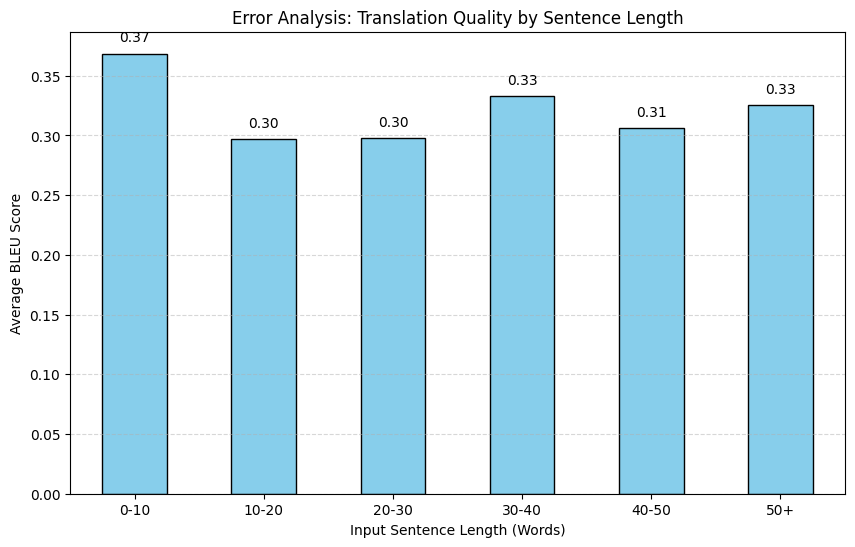


Interpretation:
- If the bar drops as length increases, your model struggles with long-term memory (common).
- If the first bar (0-10) is low, your model struggles with basic greetings/titles.


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def plot_performance_by_length(model, test_pairs, max_samples=1000):
    """
    Performs Error Analysis: Plots BLEU score vs. Sentence Length.
    """
    print("Running Error Analysis (Performance by Length)...")
    
    # 1. Generate Data
    lengths = []
    scores = []
    
    smoothing = SmoothingFunction().method1
    
    # Use a subset for speed
    subset = test_pairs[:max_samples]
    
    for en, fr_true in subset:
        try:
            # Translate
            fr_pred = model.translate(en)
            if isinstance(fr_pred, list): fr_pred = fr_pred[0] # Handle embedding model
            
            # Tokenize
            ref_tokens = word_tokenize(fr_true.lower())
            pred_tokens = word_tokenize(fr_pred.lower())
            
            # Calculate BLEU
            score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothing)
            
            # Record Length (English word count) and Score
            lengths.append(len(en.split()))
            scores.append(score)
            
        except Exception:
            continue

    # 2. Create DataFrame for Analysis
    df = pd.DataFrame({'length': lengths, 'bleu': scores})
    
    # 3. Bin the lengths (e.g., 0-10 words, 10-20 words...)
    bins = [0, 10, 20, 30, 40, 50, 100]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50+']
    df['length_bin'] = pd.cut(df['length'], bins=bins, labels=labels)
    
    # 4. Calculate Average BLEU per bin
    bin_scores = df.groupby('length_bin')['bleu'].mean()
    
    # 5. Plot
    plt.figure(figsize=(10, 6))
    bin_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    
    plt.title('Error Analysis: Translation Quality by Sentence Length')
    plt.xlabel('Input Sentence Length (Words)')
    plt.ylabel('Average BLEU Score')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=0)
    
    # Add value labels on top of bars
    for i, v in enumerate(bin_scores):
        if not np.isnan(v):
            plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
            
    plt.show()
    
    print("\nInterpretation:")
    print("- If the bar drops as length increases, your model struggles with long-term memory (common).")
    print("- If the first bar (0-10) is low, your model struggles with basic greetings/titles.")

# Run the analysis on your Best Model (Seq2Seq)
# (Ensure seq2seq_model is loaded)
plot_performance_by_length(seq2seq_model, test_pairs)

## 6. Detailed Examples and Analysis

In [27]:
# Show side-by-side comparisons for all three models
print("Side-by-Side Translation Comparison (All Three Models):\n")
num_examples = 10
for i in range(min(num_examples, len(test_pairs))):
    en, fr_true = test_pairs[i]
    fr_baseline = baseline_model.translate_preserve_case(en)
    fr_embedding = embedding_model.translate(en)
    fr_seq2seq = seq2seq_model.translate(en, num_beams=4)
    
    print(f"{'='*80}")
    print(f"Example {i+1}")
    print(f"{'='*80}")
    print(f"EN:  {en}")
    print(f"\nFR (True):      {fr_true}")
    print(f"FR (Baseline):  {fr_baseline}")
    print(f"FR (Embedding): {fr_embedding}")
    print(f"FR (Seq2Seq):   {fr_seq2seq}")
    print()

Side-by-Side Translation Comparison (All Three Models):

Example 1
EN:  You see, if we want to train professionals effectively, it is essential to teach them to understand the European and international dimensions of the market in their fields - and to do so at European level too.

FR (True):      Voyez-vous, si nous voulons former des professionnels dans une optique d'efficacité, il est essentiel, y compris au niveau européen, de les former à appréhender les dimensions européenne et internationale du marché dans leurs domaines d'activité.
FR (Baseline):  Vous que si nous nous de train professionnels de il est est de à les de je la L et la dimensions de la marché dans de domaines et de ne de à L niveau trop
FR (Embedding): La formation et l' apprentissage sont de plus en plus nettement considérés comme une ressource pour l' Europe.
FR (Seq2Seq):   Vous voyez, si nous voulons former efficacement les professionnels, il est essentiel de leur apprendre à comprendre les dimensions européenn

Generating Attention Map from: ./seq2seq_model_opus-mt-en-fr


Loading weights: 100%|██████████| 256/256 [00:00<00:00, 1849.85it/s, Materializing param=model.shared.weight]                                  
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
/home/mhayakawa/miniconda3/envs/rocm_env/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:176: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


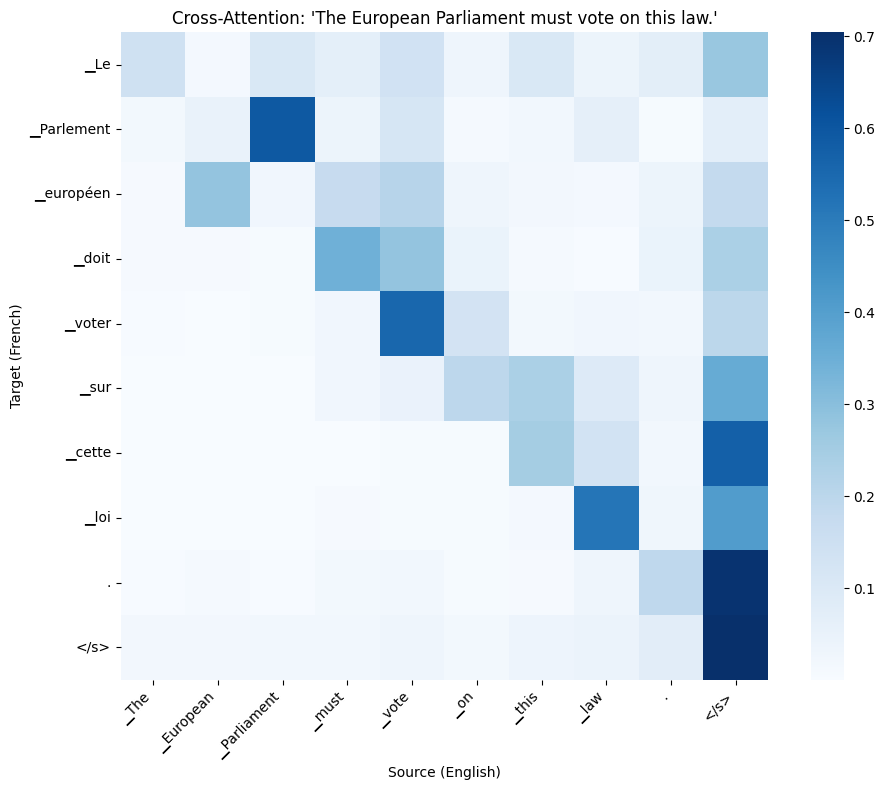

In [36]:
import warnings
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import types

# 1. Suppress the specific "tied weights" warning to keep output clean
warnings.filterwarnings("ignore", message=".*tie_word_embeddings.*")

# 2. Load the trained model with "eager" attention
model_path = "./seq2seq_model_opus-mt-en-fr" 
print(f"Generating Attention Map from: {model_path}")

try:
    # Load model
    viz_model = AutoModelForSeq2SeqLM.from_pretrained(model_path, attn_implementation="eager")
    viz_tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Move to GPU/MPS if available
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    viz_model.to(device)

    # 3. Create wrapper object
    viz_wrapper = types.SimpleNamespace()
    viz_wrapper.model = viz_model
    viz_wrapper.tokenizer = viz_tokenizer
    viz_wrapper.device = device

    # 4. Define the plotting function (Robust version)
    def plot_attention_map(model_wrapper, text):
        model = model_wrapper.model
        tokenizer = model_wrapper.tokenizer
        device = model_wrapper.device
        
        # Enable attention outputs
        model.config.output_attentions = True
        
        # Tokenize
        inputs = tokenizer(text, return_tensors="pt").to(device)
        
        # Generate with Greedy Search
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                output_attentions=True,
                return_dict_in_generate=True,
                max_length=50,
                num_beams=1 # Greedy search for simple 1-to-1 attention
            )
        
        # Get tokens
        input_tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
        output_ids = outputs.sequences[0]
        output_tokens = tokenizer.convert_ids_to_tokens(output_ids)
        
        # Extract attention
        attention_matrix = []
        for step_attentions in outputs.cross_attentions:
            # Last layer, batch 0 -> Shape: (num_heads, 1, input_len)
            last_layer_attn = step_attentions[-1][0]
            # Average heads -> Shape: (1, input_len)
            avg_attn = last_layer_attn.mean(dim=0)
            # Squeeze -> Shape: (input_len,)
            avg_attn = avg_attn.squeeze(0).cpu().numpy()
            attention_matrix.append(avg_attn)
        
        attention_matrix = np.array(attention_matrix)
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            attention_matrix,
            xticklabels=input_tokens,
            yticklabels=output_tokens[1:], 
            cmap="Blues", 
            cbar=True,
            square=True
        )
        plt.title(f"Cross-Attention: '{text}'")
        plt.xlabel("Source (English)")
        plt.ylabel("Target (French)")
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    # 5. Run it!
    test_sentence = "The European Parliament must vote on this law."
    plot_attention_map(viz_wrapper, test_sentence)

except Exception as e:
    print(f"Error: {e}")

## Summary

This notebook implemented and compared two translation approaches:

1. **Baseline (Word-for-Word)**: Simple dictionary-based translation that maps each English word to its most common French translation from the training data.

2. **Advanced (Cross-Lingual Embeddings)**: Uses multilingual sentence embeddings to find the most semantically similar French sentence from the training corpus.

The cross-lingual embedding approach should generally perform better as it considers semantic meaning rather than just word-level mappings. However, it requires more computational resources and may be slower for large candidate pools.

### Future Improvements:
- Use more sophisticated word alignment algorithms (e.g., IBM models)
- Implement phrase-based translation
- Use neural sequence-to-sequence models
- Fine-tune the embedding model on the specific domain
- Add more evaluation metrics (METEOR, ROUGE, etc.)